In [9]:
import pathlib
import os
import sys
from torch.utils.data import DataLoader
import torch
import random

PACKAGE_PARENT = pathlib.Path.cwd().parent 
SCR_DIR = os.path.join(PACKAGE_PARENT, 'src')
sys.path.append(SCR_DIR)

from config.loc_config import TRAIN_DATA_LOC, TEST_DATA_LOC, PRED_DATA_LOC, ANNOT_LOC, MODEL_SAVE_LOC, REPORT_SAVE_LOC
from config.data_config import INPUT_WIDTH, INPUT_HEIGHT, INPUT_CHANNEL, BATCH_SIZE, NUM_WORKERS
from preprocessing.utils import build_annotation_csv, check_annot_dataframe, transform_bilinear
from model.dataset import IntelDataset, create_validation_dataset
import model.cnn_model as cnn_model
from postprocessing.utils import save_model_with_timestamp, save_csv_with_timestamp, calculate_model_performance

In [6]:
import importlib
import model.dataset
import model.cnn_model as cnn_model
import config.loc_config
import postprocessing.utils
importlib.reload(model.dataset)
importlib.reload(model.cnn_model)
importlib.reload(config.loc_config)
importlib.reload(postprocessing.utils)
from model.dataset import IntelDataset, create_validation_dataset
import model.cnn_model as cnn_model
import config.loc_config
from postprocessing.utils import save_model_with_timestamp, save_csv_with_timestamp

### 1. Creating and Preprocessing Input Dataset

In [3]:
train_df = build_annotation_csv(image_location=TRAIN_DATA_LOC, annot_location=ANNOT_LOC, output_csv_name='train.csv')
test_df = build_annotation_csv(image_location=TEST_DATA_LOC, annot_location=ANNOT_LOC, output_csv_name='test.csv')
class_names = list(train_df['class_name'].unique())
print(class_names)
print(check_annot_dataframe(train_df))
print(check_annot_dataframe(test_df))

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
[(1, 'forest'), (4, 'sea'), (2, 'glacier'), (5, 'street'), (3, 'mountain'), (0, 'buildings')]
[(1, 'forest'), (4, 'sea'), (2, 'glacier'), (5, 'street'), (3, 'mountain'), (0, 'buildings')]


In [16]:
image_transform = transform_bilinear(INPUT_WIDTH, INPUT_HEIGHT)
main_dataset = IntelDataset(annot_df = train_df, transform=image_transform)
train_dataset, validation_dataset = create_validation_dataset(main_dataset, validation_proportion=0.2)
print('Train set size: ', len(train_dataset))
print('Validation set size: ', len(validation_dataset))

test_dataset = IntelDataset(annot_df = test_df, transform=image_transform)
print('Test set size: ', len(test_dataset))

11227 2807
Train set size:  11227
Validation set size:  2807
Test set size:  3000


c:\Users\phuon\OneDrive\Documents\GitHub\intel_img_clf_pytorch\venv39\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


### 2. Configuring the Dataloaders

In [12]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

### 3. Training and Exporting CNN Model

#### 3.1. With 10 Epochs

Current device: cpu
Is Model on CUDA: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 16, 224, 224]           2,320
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
            Conv2d-5         [-1, 32, 112, 112]           9,248
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
            Conv2d-8           [-1, 64, 56, 56]          36,928
            Conv2d-9           [-1, 64, 56, 56]          36,928
        MaxPool2d-10           [-1, 64, 28, 28]               0
           Linear-11                  [-1, 500]      25,088,500
           Linear-12                   [-1, 50]          25,050
           Linear-13                    [-1, 6]            

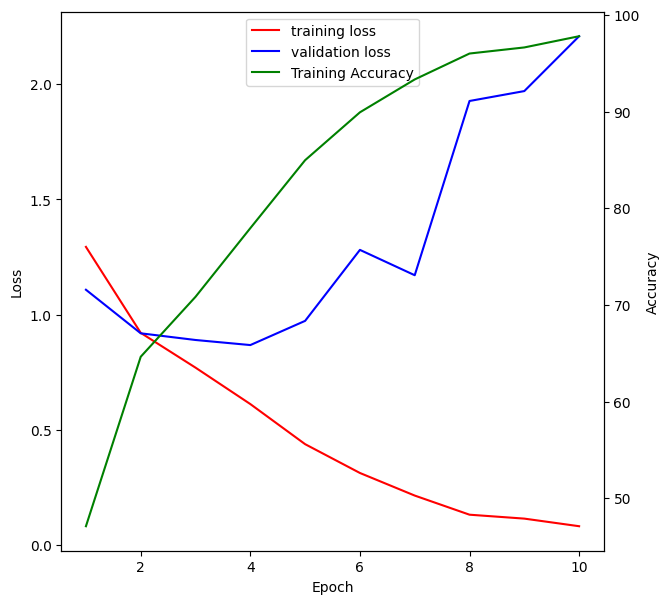

In [6]:
# initiation
model = cnn_model.MyCnnModel()
device = cnn_model.get_default_device()
cnn_model.model_prep_and_summary(model, device)
criterion = cnn_model.default_loss()
optimizer = cnn_model.default_optimizer(model = model)
num_epochs = 10

# get training results
trained_model, train_result_dict = cnn_model.train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs)
cnn_model.visualize_training(train_result_dict)

In [15]:
save_model_with_timestamp(trained_model, MODEL_SAVE_LOC)

Saved model to:  ..\data\04_model\20230107_125216_cnn_model.pt


In [23]:
save_csv_with_timestamp(train_result_dict, REPORT_SAVE_LOC)

Saved training report to:  ..\data\06_reporting\20230107_141104_training_report.csv


#### 3.2. With 5 Epochs

Current device: cpu
Is Model on CUDA: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 16, 224, 224]           2,320
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
            Conv2d-5         [-1, 32, 112, 112]           9,248
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
            Conv2d-8           [-1, 64, 56, 56]          36,928
            Conv2d-9           [-1, 64, 56, 56]          36,928
        MaxPool2d-10           [-1, 64, 28, 28]               0
           Linear-11                  [-1, 500]      25,088,500
           Linear-12                   [-1, 50]          25,050
           Linear-13                    [-1, 6]            

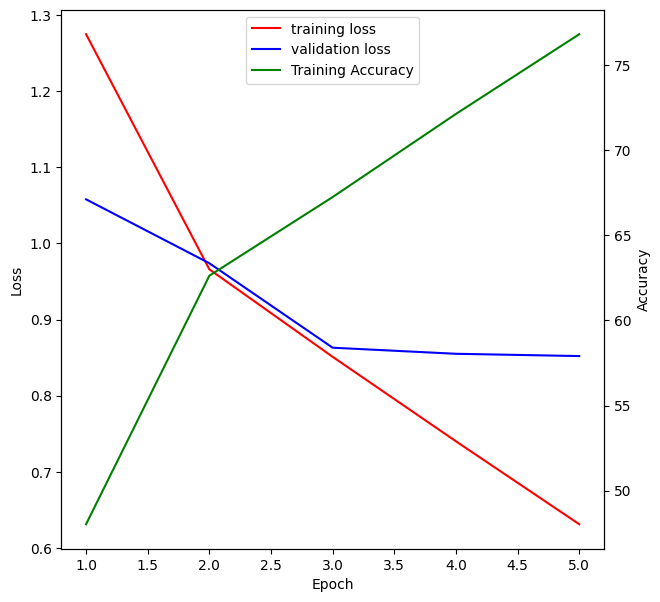

In [28]:
# initiation
model = cnn_model.MyCnnModel()
device = cnn_model.get_default_device()
cnn_model.model_prep_and_summary(model, device)
criterion = cnn_model.default_loss()
optimizer = cnn_model.default_optimizer(model = model)
num_epochs = 5

# get training results
trained_model, train_result_dict = cnn_model.train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs)
cnn_model.visualize_training(train_result_dict)

In [29]:
save_model_with_timestamp(trained_model, MODEL_SAVE_LOC)

Saved model to:  ..\data\04_model\20230107_155535_cnn_model.pt


In [30]:
save_csv_with_timestamp(train_result_dict, REPORT_SAVE_LOC)

Saved training report to:  ..\data\06_reporting\20230107_155536_training_report.csv


### 4. Testing

#### 4.1. With Model Trained with 10 Epochs

In [12]:
trained_model_list = os.listdir(MODEL_SAVE_LOC)
MODEL_10_EPOCH_PATH = os.path.join(MODEL_SAVE_LOC, trained_model_list[0])
MODEL_10_EPOCH = cnn_model.MyCnnModel()
device = cnn_model.get_default_device()
print(MODEL_10_EPOCH_PATH)
MODEL_10_EPOCH.load_state_dict(torch.load(MODEL_10_EPOCH_PATH))

..\data\04_model\20230107_125216_cnn_model.pt


<All keys matched successfully>

In [14]:
# check accuracy on test set
y_pred, y_true = cnn_model.infer(model = MODEL_10_EPOCH, device = device, data_loader = test_loader)
confusion_matrix, class_metrics, overall_metrics = calculate_model_performance(y_pred, y_true, class_names = class_names)

In [15]:
print(confusion_matrix)
print(class_metrics)
print(overall_metrics)

tensor([[325.,  15.,  37.,  47.,  46.,  76.],
        [ 14., 425.,   4.,   3.,   7.,  29.],
        [  5.,   0., 270.,  51.,  51.,   7.],
        [  2.,   5., 136., 366., 116.,   1.],
        [ 14.,   0.,  89.,  55., 283.,   4.],
        [ 77.,  29.,  17.,   3.,   7., 384.]])
           accuracy  precision  recall  f1_score
buildings     0.889      0.595   0.744     0.661
forest        0.965      0.882   0.897     0.889
glacier       0.868      0.703   0.488     0.576
mountain      0.860      0.585   0.697     0.636
sea           0.870      0.636   0.555     0.593
street        0.917      0.743   0.766     0.754
             overall
accuracy       0.684
f1_mirco       0.684
f1_macro       0.685
f1_weighted    0.681


#### 4.2. With Model Trained with 5 Epochs

In [13]:
MODEL_5_EPOCH_PATH = os.path.join(MODEL_SAVE_LOC, trained_model_list[1])
MODEL_5_EPOCH = cnn_model.MyCnnModel()
device = cnn_model.get_default_device()
print(MODEL_5_EPOCH_PATH)
MODEL_5_EPOCH.load_state_dict(torch.load(MODEL_5_EPOCH_PATH))

..\data\04_model\20230107_155535_cnn_model.pt


<All keys matched successfully>

In [17]:
y_pred, y_true = cnn_model.infer(model = MODEL_10_EPOCH, device = device, data_loader = test_loader)
confusion_matrix, class_metrics, overall_metrics = calculate_model_performance(y_pred, y_true, class_names = class_names)

In [18]:
print(confusion_matrix)
print(class_metrics)
print(overall_metrics)

tensor([[329.,  17.,  37.,  42.,  45.,  68.],
        [ 12., 430.,   4.,   1.,   4.,  31.],
        [  2.,   0., 271.,  48.,  53.,   4.],
        [  3.,   3., 132., 368., 110.,   1.],
        [  9.,   0.,  94.,  61., 291.,   6.],
        [ 82.,  24.,  15.,   5.,   7., 391.]])
           accuracy  precision  recall  f1_score
buildings     0.894      0.612   0.753     0.675
forest        0.968      0.892   0.907     0.900
glacier       0.870      0.717   0.490     0.582
mountain      0.865      0.596   0.701     0.644
sea           0.870      0.631   0.571     0.599
street        0.919      0.746   0.780     0.763
             overall
accuracy       0.693
f1_mirco       0.693
f1_macro       0.694
f1_weighted    0.690


#### 4.3. Testing a Single Image

In [27]:
image_list = os.listdir(PRED_DATA_LOC)
random_image = random.choice(image_list)
random_image_path = os.path.join(PRED_DATA_LOC, random_image)
print(random_image_path)

..\data\01_raw\seg_pred\16780.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class Index: tensor([1])
forest


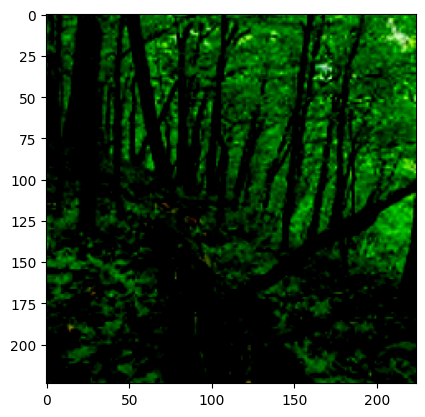

In [28]:
predicted_class_index = cnn_model.infer_single_image(model = MODEL_10_EPOCH, device = device, image_path = random_image_path, transform = image_transform)
print(class_names[predicted_class_index])